In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.time import Time 
from astropy.stats import sigma_clip
from scipy.stats import norm
from scipy.special import erfc
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html


## Plot 1: early version : generate sinusoidal $F_{true}$ 

This means that we make a time-series where 
F_true  = A*sin(t)+B

and 
sigma = constant = 25-th percentile of sorted  F_true distribution (which with A=1 and B=1 ranges from 0 to 2 ) 

then we scale the distribution of F_true values by sigma, thus considering x_true = F_true  / sigma . 

The observed points corresponding to each F_true are drawn from a Gaussian distribution   ($p(F) \sim \mathcal{N}(F_{true}, \sigma)$), centered on F_true, with a width sigma.   For a scaled x_true,  the distribution is centered on x_true, with a width of 1.

If the number of possible sources was constant with decreasing flux (increasing magnitudes), then the plot of x_true vs x_obs, assuming we draw a 100 observations at the same time of each x_true , so that there are 100 values of x_obs for each x_true  would be : 





In [ ]:
# Generate 1000 true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 
# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of 100 Gaussian draws each 
for i in range(len(x_true)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    x_obs_i = np.random.normal(loc=x_true[i], scale = 1, size = 100)
    x_obs.append(x_obs_i)

    
# Plot these points ...
%matplotlib inline
fig, ax= plt.subplots(figsize=(6,8))

for i in range(len(x_true)):
    x_obs_i = x_obs[i]
    x_true_i = x_true[i]
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    ax.scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    ax.scatter(x_true_i, x_true_i, color='red', lw=0)
ax.set_ylabel(r'$F_{true} / \sigma$', fontsize=15)
ax.set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.savefig(dir_save+'Sim_LC_x_obs_vs_x_true_constant_counts.png')

However, the total number of sources increases with decreasing flux (increasing magnitudes), according to Euclidean cumulative distribution function:

$N(>F) \propto F ^{-1.5}$  , or $N(<m) \propto 10^ {0.6 m }$

this means that our distribution of possible flux as we go to fainter objects (lower S/N) becomes wider , as there is more x_obs points per each x_true towards the faint end : 

In [1]:
# Generate 1000 true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 

# Choose points with S/N > 0.2 ... 
n0 = 100
mask_close_zero = x_true>0.2
n = n0 * x_true[mask_close_zero] **(-1.5)+50
plt.plot(x_true[mask_close_zero], np.log10(n))
plt.xlabel('x_true')
plt.ylabel('log(cdf(counts))')

NameError: name 'np' is not defined

Make a plot that shows how for each x_true we draw  x_obs points ,  where number of points comes from an Euclidean cdf, which describes  N(x > x_true).  Thus I need to recover the pdf from the cdf to get N(x = x_true):

In [ ]:
# Generate N true points 
time = np.linspace(start=0,stop=2*np.pi, num=100)
f_true = np.sin(time)+1.0

# Define  a sigma as 20% of the 25-th percentile .. 
sigma = np.percentile(f_true,25)
x_true = f_true / sigma 

# grab only points that are far enough from 0 
# that the number of counts does not become exponentially large... 
mask_close_zero = x_true>0.02

sorted_x = np.sort(x_true[mask_close_zero])

n_counts_cdf = n0 * sorted_x **(-1.5)+50
n_counts_pdf = np.ones_like(n_counts_cdf)

for i in range(len(sorted_x)-1):
    rise = n_counts_cdf[i] - n_counts_cdf[i+1]
    run  = abs(sorted_x[i+1] - sorted_x[i])
    n_counts_pdf[i] = rise / run 

n_counts = n_counts_pdf

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n)
    x_obs.append(x_obs_i)

%matplotlib inline
fig, ax= plt.subplots(1,2,figsize=(12,8), sharey=True)

for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]
    x_true_i = sorted_x[i]
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    ax[0].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    ax[0].scatter(x_true_i, x_true_i, color='red', lw=0)
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    ax[0].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    ax[0].scatter(x_true_i+1, x_true_i, color='green', lw=0)
ax[1].plot(np.log10(n_counts), sorted_x, marker='D')

fig.subplots_adjust(wspace=0.1)
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$\log_{10}(N_{F>F_{true}})$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()
ax[1].grid()
ax[0].axvline(x=0, color='orange', ls='--', lw=4)
#plt.tight_layout()
fig.suptitle('Gaussian draws with Euclidean count for observed points', fontsize=15)
plt.savefig(dir_save+'Sim_LC_x_obs_vs_x_true_Euclidean_counts.png')

## Plot 1 : Generate static $F_{true}$ distribution, consider an Euclidean count $N_{obs}$ of  $F_{obs}$  drawn from an underlying Gaussian $p(F_{obs})$ 

In [2]:
dir_save = '/astro/users/suberlak/S13Agg_analysis/data_products/'

e scale the distribution of F_true values by sigma, thus considering x_true = F_true  / sigma . 

The observed points corresponding to each F_true are drawn from a Gaussian distribution   ($p(F) \sim \mathcal{N}(F_{true}, \sigma)$), centered on F_true, with a width sigma.   For a scaled x_true,  the distribution is centered on x_true, with a width of 1.

If the number of possible sources was constant with decreasing flux (increasing magnitudes), then the plot of x_true vs x_obs, assuming we draw a 100 observations at the same time of each x_true , so that there are 100 values of x_obs for each x_true  would be : 


In [2]:
# Generate f_true 
fmin = 0
fmax = 1
n_points_f_true = 1000

f_true = np.linspace(fmin, fmax, n_points_f_true)

sigma_arr = []
median_arr = []
percentile = []
for i in range(10,75):
    percentile.append(i)
    sigma = np.percentile(f_true,i)
    sigma_arr.append(sigma)
    median_arr.append(np.median(f_true / sigma )) 
plt.scatter(median_arr,sigma_arr)

In [41]:
percentile[median_arr==2]

10

In [44]:
# Thus, choose sigma to be the tenth percentile, so that the median(flux/sigma) == 2  : 

sigma = np.percentile(f_true,10)
np.median(f_true/sigma)

5.0


However, the total number of sources increases with decreasing flux (increasing magnitudes), according to Euclidean cumulative distribution function:

$N(>F) \propto F ^{-1.5}$  , or $N(<m) \propto 10^ {0.6 m }$

this means that our distribution of possible flux as we go to fainter objects (lower S/N) becomes wider , as there is more x_obs points per each x_true towards the faint end : 

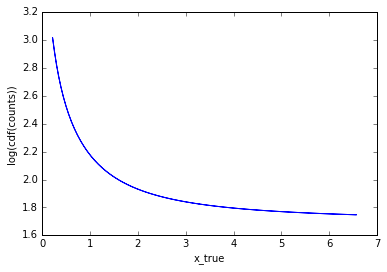

In [11]:

# Choose points with S/N > 0.2 ... 
n0 = 100
mask_close_zero = x_true>0.2
n = n0 * x_true[mask_close_zero] **(-1.5)+50
plt.plot(x_true[mask_close_zero], np.log10(n))
plt.xlabel('x_true')
plt.ylabel('log(cdf(counts))')

Make a plot that shows how for each x_true we draw  x_obs points ,  where number of points comes from an Euclidean cdf, which describes  N(x > x_true).  Thus I need to recover the pdf from the cdf to get N(x = x_true):

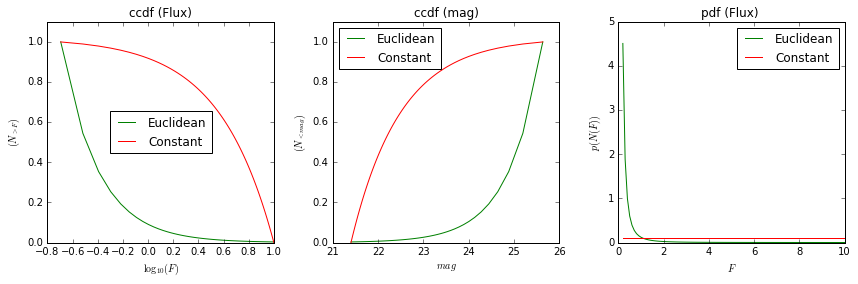

In [145]:
%matplotlib inline
# compare Euclidean and constant counts...
fig,ax = plt.subplots(1,3, figsize=(12,4))

# Flux 
fmin = 0
fmax = 1
n_points_f_true = 100

f_true = np.linspace(fmin, fmax, n_points_f_true)
sigma = np.percentile(f_true,10)
x_true = f_true / sigma 

# grab only points that are far enough from 0 
# that the number of counts does not become exponentially large... 
mask_close_zero = x_true>0.2
sorted_x = np.sort(x_true[mask_close_zero])

F = sorted_x
delF = F[1]-F[0]

# left
ax[0].set_xlabel(r'$\log_{10}(F)$')
ax[0].set_ylabel(r'$(N_{>F})$')
ax[0].set_title('ccdf (Flux)')
ax[0].set_ylim(0,1.1)
#ax[0].set_xlim(-0.8,1.1)

# middle 
ax[1].set_xlabel(r'$mag$')
ax[1].set_ylabel(r'$(N_{<mag})$')
ax[1].set_title('ccdf (mag)')
ax[1].set_ylim(0,1.1)

# right 
ax[2].set_xlabel(r'$F$')
ax[2].set_ylabel(r'$p(N(F))$')
ax[2].set_title('pdf (Flux) ')

# Euclidean distribution of N vs Flux 
n0 = 50 
euc_ccdf_count = n0*F **(-1.5)
euc_ccdf_norm  = euc_ccdf_count / euc_ccdf_count[0]
calib = 1e-29
mag = -2.5*np.log10(F*calib)-48.6

euc_pdf_norm = np.zeros_like(euc_ccdf_norm)

for i in range(len(sorted_x)-1):
    rise = euc_ccdf_norm[i] - euc_ccdf_norm[i+1]
    run  = abs(F[i+1] - F[i])
    euc_pdf_norm[i] = rise / run 

# plot  log(flux) vs  log(p(N_cdf) 
ax[0].plot(np.log10(F), euc_ccdf_norm , color='green', label='Euclidean')

# plot   mag   vs log(N_cdf) 
ax[1].plot(mag, euc_ccdf_norm, color='green', label='Euclidean')

# plot N_pdf vs flux 
ax[2].plot(F, euc_pdf_norm, color='green', label='Euclidean')


# Constant distribution of N vs flux 
const_pdf = 0.5*n0*np.ones_like(F)
norm = np.sum(delF*const_pdf)
const_pdf_norm = const_pdf / norm 

const_ccdf_norm = np.zeros_like(const_pdf)
for i in range(len(const_pdf_norm)):
    const_ccdf_norm[i]= np.sum(const_pdf_norm[i+1:])

const_ccdf_norm = const_ccdf_norm / const_ccdf_norm[0]

#   plot  log(flux) vs  log(N_cdf) 
ax[0].plot(np.log10(F), const_ccdf_norm, color='red', label='Constant')

# plot   mag   vs log(N_cdf) 
ax[1].plot(mag, const_ccdf_norm, color='red', label='Constant')

# plot N_pdf vs flux 
ax[2].plot(F,const_pdf_norm, color='red', label='Constant')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend()

plt.tight_layout()

#plt.scatter(np.log10(sorted_x), np.log10(n_counts_cdf))

#plt.scatter(mag, np.log10(n_counts_cdf))

In [383]:
# The same calculation, showing exactly what I am doing :
# for  Euclidean  , cdf is given (how many counts up to a certain Flux, going from above : N (>F), 
# NOT the traditional cdf, where we think about up to a certain Flux from below)
# This is because it is derived as a number of objects up to a certain distance : N(<d),  
# which translates to  N(>F) or  N(<m)   
#(brighter than a certain flux or  equialently, with a magnitude 
# smaller than  a certain magnitude )

euc_cdf = n0*F **(-1.5)

# pdf from cdf 
euc_pdf = np.zeros_like(euc_cdf)
for i in range(len(F)-1):
    rise = euc_cdf[i] - euc_cdf[i+1]
    run  = abs(F[i+1] - F[i])
    euc_pdf[i] = rise / run 


const_pdf = n0*np.ones_like(F)

# cdf from pdf 
const_cdf = np.zeros_like(const_pdf)
for i in range(len(const_pdf)):
    const_cdf[i]= np.sum(const_pdf[i:])



In [495]:
scale = 100
# Euclidean distribution of N vs Flux 
euc_ccdf_count = n0*F **(-1.5)
euc_ccdf_norm  = euc_ccdf_count / euc_ccdf_count[0]

euc_pdf_count = np.zeros_like(euc_ccdf_norm)

for i in range(len(sorted_x)-1):
    rise = euc_ccdf_count[i] - euc_ccdf_count[i+1]
    run  = abs(F[i+1] - F[i])
    euc_pdf_count[i] = rise / run 

euc_pdf_norm = euc_pdf_count / np.sum(delF*euc_pdf_count)

euc_pdf_count = scale * euc_pdf_norm

# Constant distribution of N vs flux 
const_pdf_count = 0.5*n0*np.ones_like(F)
norm = np.sum(delF*const_pdf_count)
const_pdf_norm = const_pdf_count / norm 

const_pdf_count = scale * const_pdf_norm

const_ccdf_norm = np.zeros_like(const_pdf)
for i in range(len(const_pdf_norm)):
    const_ccdf_norm[i]= np.sum(const_pdf_norm[i+1:])

const_ccdf_norm = const_ccdf_norm / const_ccdf_norm[0]
const_ccdf_count = const_ccdf_norm * euc_ccdf_count[0]

In [136]:
np.shape(H)

(100, 100)

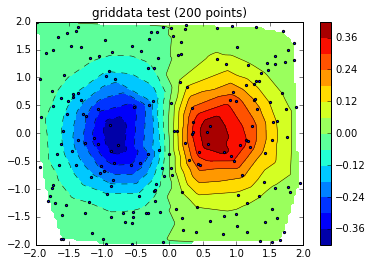

In [3]:
%matplotlib inline
import numpy as np
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform
# make up some randomly distributed data
npts = 200
x = uniform(-2,2,npts)
y = uniform(-2,2,npts)
z = x*np.exp(-x**2-y**2)
# define grid.
xi = np.linspace(-2.1,2.1,100)
yi = np.linspace(-2.1,2.1,100)
# grid the data.
zi = griddata(x,y,z,xi,yi, interp='linear')
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(x,y,marker='o',c='b',s=5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('griddata test (%d points)' % npts)
plt.show()

In [3]:
# I had to modify scatter contour in a small way so that the 
# zorder can be inverted, and I don't get points on top of my contours....

def scatter_contour(x, y,
                    levels=10,
                    threshold=100,
                    log_counts=False,
                    histogram2d_args=None,
                    plot_args=None,
                    contour_args=None,
                    filled_contour=True,
                    ax=None):
    """Scatter plot with contour over dense regions
    Parameters
    ----------
    x, y : arrays
        x and y data for the contour plot
    levels : integer or array (optional, default=10)
        number of contour levels, or array of contour levels
    threshold : float (default=100)
        number of points per 2D bin at which to begin drawing contours
    log_counts :boolean (optional)
        if True, contour levels are the base-10 logarithm of bin counts.
    histogram2d_args : dict
        keyword arguments passed to numpy.histogram2d
        see doc string of numpy.histogram2d for more information
    plot_args : dict
        keyword arguments passed to plt.plot.  By default it will use
        dict(marker='.', linestyle='none').
        see doc string of pylab.plot for more information
    contour_args : dict
        keyword arguments passed to plt.contourf or plt.contour
        see doc string of pylab.contourf for more information
    filled_contour : bool
        If True (default) use filled contours. Otherwise, use contour outlines.
    ax : pylab.Axes instance
        the axes on which to plot.  If not specified, the current
        axes will be used
    Returns
    -------
    points, contours :
       points is the return value of ax.plot()
       contours is the return value of ax.contour or ax.contourf
    """
    x = np.asarray(x)
    y = np.asarray(y)

    default_contour_args = dict(zorder=2)  # then plot scatter 
    default_plot_args = dict(marker='.', linestyle='none', zorder=1)  # first plot dots

    if plot_args is not None:
        default_plot_args.update(plot_args)
    plot_args = default_plot_args

    if contour_args is not None:
        default_contour_args.update(contour_args)
    contour_args = default_contour_args

    if histogram2d_args is None:
        histogram2d_args = {}

    if contour_args is None:
        contour_args = {}

    if ax is None:
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        ax = plt.gca()

    H, xbins, ybins = np.histogram2d(x, y, **histogram2d_args)

    if log_counts:
        H = np.log10(1 + H)
        threshold = np.log10(1 + threshold)

    levels = np.asarray(levels)

    if levels.size == 1:
        levels = np.linspace(threshold, H.max(), levels)

    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

    i_min = np.argmin(levels)

    # draw a zero-width line: this gives us the outer polygon to
    # reduce the number of points we draw
    # somewhat hackish... we could probably get the same info from
    # the full contour plot below.
    outline = ax.contour(H.T, levels[i_min:i_min + 1],
                         linewidths=0, extent=extent,
                         alpha=0)

    if filled_contour:
        contours = ax.contourf(H.T, levels, extent=extent, **contour_args)
    else:
        contours = ax.contour(H.T, levels, extent=extent, **contour_args)

    X = np.hstack([x[:, None], y[:, None]])

    if len(outline.allsegs[0]) > 0:
        outer_poly = outline.allsegs[0][0]
        try:
            # this works in newer matplotlib versions
            from matplotlib.path import Path
            points_inside = Path(outer_poly).contains_points(X)
        except:
            # this works in older matplotlib versions
            import matplotlib.nxutils as nx
            points_inside = nx.points_inside_poly(X, outer_poly)

        Xplot = X[~points_inside]
    else:
        Xplot = X

    points = ax.plot(Xplot[:, 0], Xplot[:, 1], **plot_args)
    #points = np.empty(0)
    return points, contours

In [4]:
#from astroML.plotting import scatter_contour
#fig = plt.figure(figsize=(5, 5))
#fig, ax = plt.subplots(2,1,figsize=(6,8))


import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2, 5)
ax = dict()
ax[0] = plt.subplot(gs[0, :4])
ax[1] = plt.subplot(gs[1, :4])
ax[2] = plt.subplot(gs[0, 4])
ax[3] = plt.subplot(gs[1, 4])

key = x_obs_dic.keys()[0]
axis = ax[0]
point, contour = scatter_contour(x_obs_dic[key],x_true_dic[key],log_counts=True, threshold=40, ax=axis,filled_contour=True,
            histogram2d_args=dict(bins=15),
            plot_args=dict(marker='.', linestyle='none', color='blue', lw=0, alpha=0.8, markersize=2),
            contour_args=dict( cmap=plt.cm.Blues_r))    


#   colorbar()  takes either  ax : the axis to which add colorbar,  
# or  cax,  which is the actual colorbar axis 

# make a colorbar 
colorbar_ax = fig.add_axes([0.15, 0.86, 0.3, 0.03])
colorbar = fig.colorbar(mappable=contour,  cax=colorbar_ax, orientation='horizontal', format='%.1f')
for label in colorbar.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
    #yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
#colorbar = fig.colorbar(mappable=contour,  ax=axis, orientation='vertical')

#plt.colorbar(mappable=contour, ax = colorbar_ax, orientation='horizontal')
#hist, bins = np.histogram(x_true_dic[key], bins=15, normed=True)
#bin_cen = 0.5 * (bins[:-1] + bins[1:])
ax[2].plot(np.log10(euc_pdf_count) , F,'-k', drawstyle='steps')
ax[2].xaxis.set_major_formatter(plt.NullFormatter())

key = x_obs_dic.keys()[1]
axis = ax[1]
point, contour = scatter_contour(x_obs_dic[key],x_true_dic[key],log_counts=True, threshold=40, ax=axis,filled_contour=True,
            histogram2d_args=dict(bins=10),
            plot_args=dict(marker='.', linestyle='none', color='blue', lw=0, alpha=0.8, markersize=2),
            contour_args=dict( cmap=plt.cm.Blues_r))  

#hist, bins = np.histogram(x_true_dic[key], bins=10, normed=False)
#bin_cen = 0.5 * (bins[:-1] + bins[1:])
#ax[3].plot(hist, bin_cen, '-k', drawstyle='steps')
ax[3].plot(const_pdf_count ,F, '-k', drawstyle='steps')
#ax[3].xaxis.set_major_formatter(plt.NullFormatter())
ax[3].set_xticklabels(ax[3].get_xticklabels())
#plt.colorbar(mappable=contour, ax = axis)
# http://matplotlib.org/api/lines_api.html 



NameError: name 'x_obs_dic' is not defined

In [30]:
for label in  colorbar.ax.xaxis.get_ticklabels() : 
    print label

Text(0,0,u'1.613')
Text(0.111111,0,u'1.852')
Text(0.222222,0,u'2.092')
Text(0.333333,0,u'2.331')
Text(0.444444,0,u'2.571')
Text(0.555556,0,u'2.810')
Text(0.666667,0,u'3.050')
Text(0.777778,0,u'3.289')
Text(0.888889,0,u'3.529')
Text(1,0,u'3.768')


In [ ]:
Early version : 

In [5]:
import numpy as np
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt

nbins=30
x = x_obs_dic['N_const']
y =  x_true_dic['N_const']
H, xedges, yedges = np.histogram2d(x,y,bins=nbins)
H[np.isnan(H)] =0 
z_reduce  = H # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

ncont = 10
CS = plt.contour(xedges[1:],yedges[1:],z,ncont,linewidths=0.5,colors='k')
CS = plt.contourf(xedges[1:],yedges[1:],z,ncont,cmap=plt.cm.Blues)
#CS = plt.contourf(xi,yi,zi,15,)

NameError: name 'x_obs_dic' is not defined

In [6]:
gs = gridspec.GridSpec(2,8)
ax[0] = plt.subplot(gs[0, :5])  # upper row, first two cols 
ax[1] = plt.subplot(gs[1, :5])  # bottom row, first two cols 
ax[2] = plt.subplot(gs[:, 6:])  # span both rows, only second col 

ax[3] = plt.subplot(gs[0,5]) # marginalize F_true for Euclidean3
ax[4] = plt.subplot(gs[1,5])

5.0


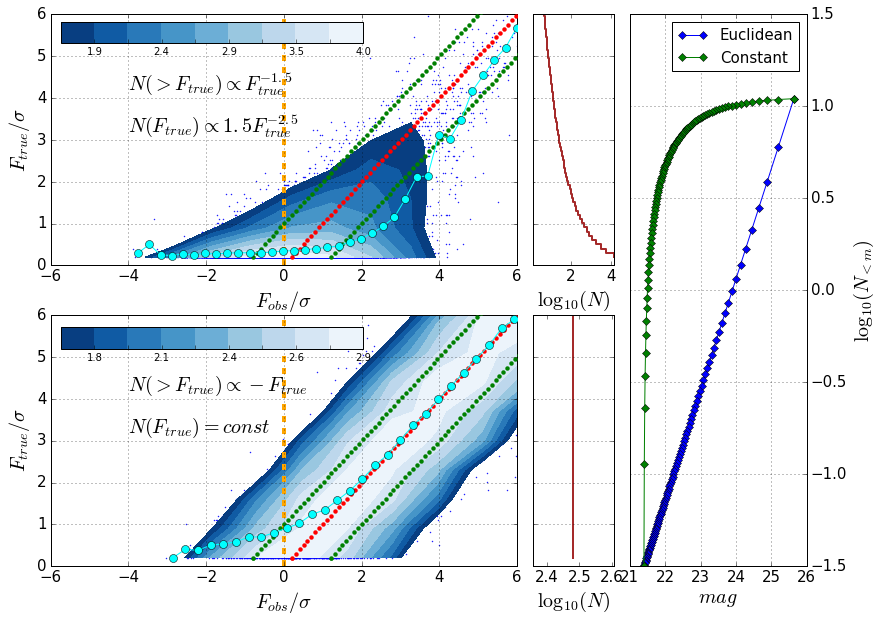

In [26]:
# define canvas object using gridspec 
%matplotlib inline
from scipy.stats import binned_statistic
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14,9.88))
gs = gridspec.GridSpec(2,8)  # (nrows, ncols)
ax = dict()
ax[0] = plt.subplot(gs[0, :5])  # upper row, first two cols 
ax[1] = plt.subplot(gs[1, :5])  # bottom row, first two cols 
ax[2] = plt.subplot(gs[:, 6:])  # span both rows, only second col 

ax[3] = plt.subplot(gs[0,5]) # marginalize F_true for Euclidean
ax[4] = plt.subplot(gs[1,5]) # marginalize F_true for constant 

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[2].set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=20)
ax[2].set_xlabel(r'$mag$', fontsize=20)
gs.update(left=0.15,hspace=0.2,wspace=0.2)

# Plotting mean F_true : 
marker_size = 8 
marker_color = 'cyan'
marker_type = 'o'

# Generate f_true 
fmin = 0
fmax = 1
n_points_f_true = 100

f_true = np.linspace(fmin, fmax, n_points_f_true)
sigma = np.percentile(f_true,10)

x_true = f_true / sigma 
print np.median(x_true)
# grab only points that are far enough from 0 
# that the number of counts does not become exponentially large... 
mask_close_zero = x_true>0.2

sorted_x = np.sort(x_true[mask_close_zero])
F = sorted_x
delF = F[1]-F[0]
##    DEFINE   EUCLIDEAN AND  CONSTANT  DISTRIBUTIONS  


scale = 3000 # by what factor shall we scale the number of point  ? 
# Euclidean distribution of N vs Flux 
euc_ccdf_count = F **(-1.5)
euc_ccdf_norm  = euc_ccdf_count / euc_ccdf_count[0]

euc_pdf_count = np.zeros_like(euc_ccdf_norm)

for i in range(len(sorted_x)-1):
    rise = euc_ccdf_count[i] - euc_ccdf_count[i+1]
    run  = abs(F[i+1] - F[i])
    euc_pdf_count[i] = rise / run 

euc_pdf_norm = euc_pdf_count / np.sum(delF*euc_pdf_count)
euc_pdf_count = scale * euc_pdf_norm

# Constant distribution of N vs flux 
const_pdf_count = 0.5*np.ones_like(F)
norm = np.sum(delF*const_pdf_count)
const_pdf_norm = const_pdf_count / norm 

const_pdf_count = scale * const_pdf_norm

const_ccdf_norm = np.zeros_like(const_pdf_count)
for i in range(len(const_pdf_norm)):
    const_ccdf_norm[i]= np.sum(const_pdf_norm[i+1:])

const_ccdf_norm = const_ccdf_norm / const_ccdf_norm[0]
const_ccdf_count = const_ccdf_norm * euc_ccdf_count[0]

# Make a dictionary to store x_obs and x_true 

x_obs_dic = dict()
x_true_dic = dict()

## EUCLIDEAN DISTRIBUTION 

n_counts = euc_pdf_count

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n_draw = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n_draw)
    x_obs.append(x_obs_i)


x_obs_flatten = np.zeros(0)
x_true_flatten = np.zeros(0)
for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]  # an array of N_draw values  drawn from a Gaussian, 
                        # n_draw Euclidean, Gaussian centered on x_true 
    x_true_i = sorted_x[i]  #  a single value corresponding to the true measurement 
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    #ax[0].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    #ax[0].scatter(x_true_i, x_true_i, color='red', lw=0)
    #ax[0].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    #ax[0].scatter(x_true_i+1, x_true_i, color='green', lw=0)
    # flatten x_obs and x_true,  by storing a N_obs array, where for each x_obs there is an x_true:
    x_obs_flatten =  np.append(x_obs_flatten,x_obs_i)
    x_true_flatten = np.append(x_true_flatten, x_true_arr)
    
x_obs_dic['N_euclid'] = x_obs_flatten
x_true_dic['N_euclid'] = x_true_flatten



##  CONSTANT  DISTRIBUTION 

n_counts = const_pdf_count

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n_draw = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n_draw)
    x_obs.append(x_obs_i)


x_obs_flatten = np.zeros(0)
x_true_flatten = np.zeros(0)
for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]  # an array of N_draw values  drawn from a Gaussian, 
                        # n_draw Euclidean, Gaussian centered on x_true 
    x_true_i = sorted_x[i]  #  a single value corresponding to the true measurement 
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    #ax[1].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    ax[1].scatter(x_true_i, x_true_i, color='red', lw=0)
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    ax[1].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    ax[1].scatter(x_true_i+1, x_true_i, color='green', lw=0)
    
    # flatten x_obs and x_true,  by storing a N_obs array, where for each x_obs there is an x_true:
    x_obs_flatten =  np.append(x_obs_flatten,x_obs_i)
    x_true_flatten = np.append(x_true_flatten, x_true_arr)


# Save the x_obs vs x_true for this N(F) to a dict 
x_obs_dic['N_const'] = x_obs_flatten
x_true_dic['N_const'] = x_true_flatten


# Both AXES: 
# OVERPLOT THE SCATTER CONTOUR OF UNDERLYING SAMPLE POINTS

y0_cbar = [0.86,0.43]
x0_cbar = 0.16
dx_cbar = 0.3
dy_cbar = 0.03

for i in range(2):
    key = x_obs_dic.keys()[i]
    axis = ax[i]
    points, contours = scatter_contour(x_obs_dic[key],x_true_dic[key],log_counts=True, threshold=40, ax=axis,filled_contour=True,
            histogram2d_args=dict(bins=15),
            plot_args=dict(marker='.', linestyle='none', color='blue', lw=0, alpha=0.8, markersize=2),
            contour_args=dict( cmap=plt.cm.Blues_r)) 
    #http://matplotlib.org/users/transforms_tutorial.html
    colorbar_ax = fig.add_axes([x0_cbar, y0_cbar[i], dx_cbar, dy_cbar])
    colorbar = fig.colorbar(mappable=contours,  cax=colorbar_ax, orientation='horizontal', format='%.1f')
    for label in colorbar.ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

   
    
# OVERPLOT MEAN X_TRUE BINNED ALONG X_OBS 

for i in range(2):
    key = x_obs_dic.keys()[i]
    stats = binned_statistic(x=x_obs_dic[key], values=x_true_dic[key], statistic='mean', bins=50)
    statistic, bin_edges, bin_number = stats[0], stats[1], stats[2]
    bin_center = (bin_edges[:-1] + bin_edges[1:])/2
    ax[i].plot(bin_center, statistic,  marker = marker_type, color=marker_color, markersize=marker_size, zorder=3)



# OVERPLOT THE MEAN AND THE +/1 SIGMA 

for i in range(2):
    # plot the red dots
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    ax[i].scatter(sorted_x, sorted_x, color='red', lw=0, zorder=3)

    # plot the +/- sigma 
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    ax[i].scatter(sorted_x-1, sorted_x, color='green', lw=0, zorder=3)
    ax[i].scatter(sorted_x+1, sorted_x, color='green', lw=0, zorder=3)


# AXIS   LABELS ,  LIMITS ..... 
xlim = [-6,6]
ylim = [0.01, 6]

# Set the labels, limits, etc for top panel
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].grid()
ax[0].axvline(x=0, color='orange', ls='--', lw=4)    
ax[0].text(-4,4.2, r'$N(>F_{true}) \propto F_{true}^{-1.5}$', fontsize=20)  # in data coordinates 
ax[0].text(-4,3.2, r'$N(F_{true})  \propto 1.5 F_{true}^{-2.5}$', fontsize=20)  # in data coordinates 
    
# Set the labels, limits, etc for bottom panel
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()
ax[1].axvline(x=0, color='orange', ls='--', lw=4)
ax[1].text(-4,4.2, r'$N(>F_{true}) \propto -F_{true}$', fontsize=20) 
ax[1].text(-4,3.2, r'$N(F_{true}) = const$', fontsize=20) 


#  PLOT MARGINALIZED F_TRUE  (I.E. THE COUNT OF DISTRIBUTIONS)

ax[3].plot(np.log10(euc_pdf_count) , F,'-k', drawstyle='steps', lw=2, color='brown')
ax[4].plot(np.log10(const_pdf_count) , F,'-k', drawstyle='steps', lw=2, color='brown')

for i in [3,4]:
    ax[i].set_yticks([1,3,5], minor=False)
    ax[i].set_yticks([2,4], minor=True)
    #ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    #ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].set_ylim(ylim[0], ylim[1])
    
    ax[i].set_xlabel(r'$\log_{10}(N)$', fontsize=20)
    ax[i].locator_params(tight=True, nbins=4)
    ax[i].yaxis.grid(True, which='both')
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    #ax[i].set_xticklabels(ax[i].get_xticklabels()[::2])   
#cbar.set_ticklabels(cbar.get_ticklabels()[::2])

# Plot the cumulative number of points as log(N (m<m_true)) vs mag  to 
# show the power law behavior 
# convert flux_true  to mag_true using arbitrary zero-point... 
zero_point = 48.6
f_scale = 1e-28
#mask_x_true_lims = (sorted_x < ylim[1]) & (sorted_x > ylim[0])
#sorted_x_true = sorted_x[mask_x_true_lims]
mag_true = -2.5*np.log10(sorted_x * sigma * f_scale) - zero_point 
const_ccdf_count[-1] = euc_ccdf_count[-1] 
ax[2].plot(mag_true, np.log10(euc_ccdf_count), marker='D', label='Euclidean')
ax[2].plot(mag_true, np.log10(const_ccdf_count), marker='D', label='Constant')
#ax[2].set_ylim(ymax=25.7)
ax[2].grid()
ax[2].legend(loc='best', fontsize=15)

ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
#ax[2].set_ylim(ax[1].get_ylim()[::-1])
#plt.tight_layout()

#fig.subplots_adjust(wspace=0.1)
#plt.tight_layout()
dir_save = '/astro/users/suberlak/S13Agg_analysis/data_products/'
plt.savefig(dir_save+'Fig1_Euclidean_const_counts.png',bbox_inches='tight')

In [15]:
euc_ccdf_count = F **(-1.5)
euc_ccdf_norm  = euc_ccdf_count / euc_ccdf_count[0]

# recovering pdf from 
euc_pdf_count = np.zeros_like(euc_ccdf_norm)

for i in range(len(sorted_x)-1):
    rise = euc_ccdf_count[i] - euc_ccdf_count[i+1]
    run  = abs(F[i+1] - F[i])
    euc_pdf_count[i] = rise / run 

euc_pdf_norm = euc_pdf_count / np.sum(delF*euc_pdf_count)
euc_pdf_count = scale * euc_pdf_norm

98

5.0


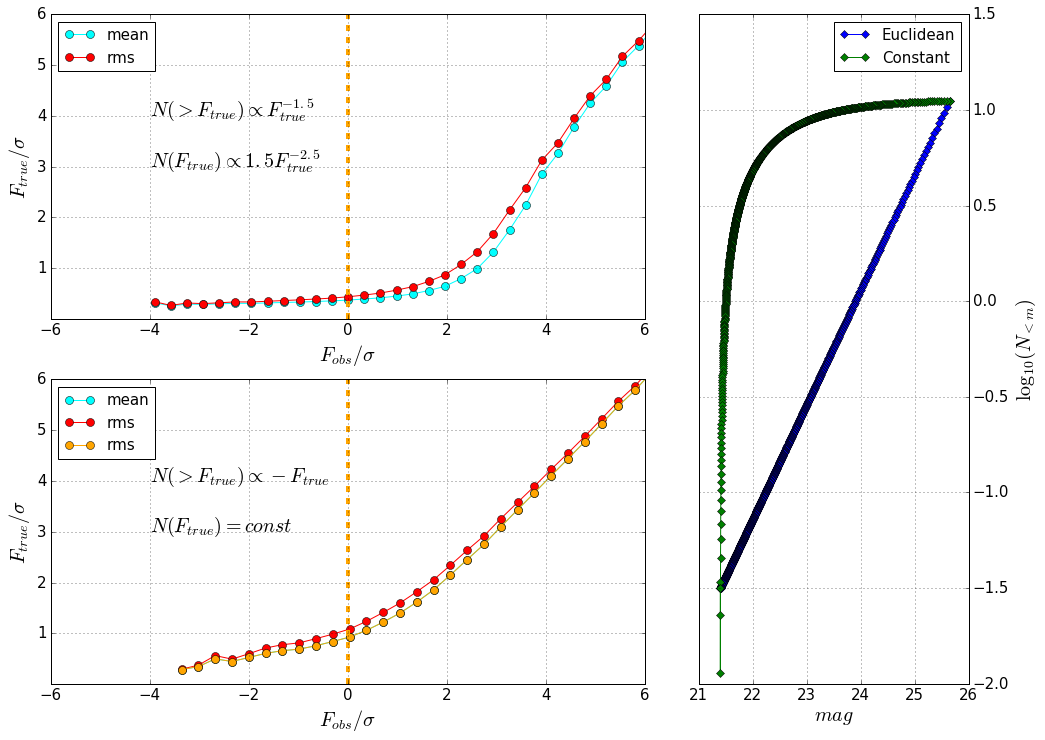

In [38]:
import matplotlib.pyplot as plt 
# Calculate the mean and plot only that .... 

# define canvas object using gridspec 
%matplotlib inline

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(17,12))
gs = gridspec.GridSpec(2, 3)
ax = dict()
ax[0] = plt.subplot(gs[0, :2])
ax[1] = plt.subplot(gs[1, :2])
ax[2] = plt.subplot(gs[:2, 2])
for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[2].set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=20)
ax[2].set_xlabel(r'$mag$', fontsize=20)
gs.update(left=0.15,hspace=0.2,wspace=0.2)

# Plotting mean F_true : 
marker_size = 8 
marker_color = 'cyan'
marker_type = 'o'

# Generate f_true 
fmin = 0
fmax = 1
n_points_f_true = 1000

f_true = np.linspace(fmin, fmax, n_points_f_true)
sigma = np.percentile(f_true,10)

x_true = f_true / sigma 
print np.median(x_true)
# grab only points that are far enough from 0 
# that the number of counts does not become exponentially large... 
mask_close_zero = x_true>0.2

sorted_x = np.sort(x_true[mask_close_zero])
F = sorted_x
delF = F[1]  - F[0]
##    DEFINE   EUCLIDEAN AND  CONSTANT  DISTRIBUTIONS  


scale = 4000
# Euclidean distribution of N vs Flux 
euc_ccdf_count = F **(-1.5)
euc_ccdf_norm  = euc_ccdf_count / euc_ccdf_count[0]

euc_pdf_count = np.zeros_like(euc_ccdf_norm)

for i in range(len(sorted_x)-1):
    rise = euc_ccdf_count[i] - euc_ccdf_count[i+1]
    run  = abs(F[i+1] - F[i])
    euc_pdf_count[i] = rise / run 

euc_pdf_norm = euc_pdf_count / np.sum(delF*euc_pdf_count)
euc_pdf_count = scale * euc_pdf_norm

# Constant distribution of N vs flux 
const_pdf_count = 0.5*np.ones_like(F)
norm = np.sum(delF*const_pdf_count)
const_pdf_norm = const_pdf_count / norm 

const_pdf_count = scale * const_pdf_norm

const_ccdf_norm = np.zeros_like(const_pdf_count)
for i in range(len(const_pdf_norm)):
    const_ccdf_norm[i]= np.sum(const_pdf_norm[i+1:])

const_ccdf_norm = const_ccdf_norm / const_ccdf_norm[0]
const_ccdf_count = const_ccdf_norm * euc_ccdf_count[0]


## PLOT EUCLIDEAN DISTRIBUTION 

n_counts = euc_pdf_count

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n_draw = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n_draw)
    x_obs.append(x_obs_i)


x_obs_flatten = np.zeros(0)
x_true_flatten = np.zeros(0)
for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]  # an array of N_draw values  drawn from a Gaussian, 
                        # n_draw Euclidean, Gaussian centered on x_true 
    x_true_i = sorted_x[i]  #  a single value corresponding to the true measurement 
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    #ax[0].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    #ax[0].scatter(x_true_i, x_true_i, color='red', lw=0)
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    #ax[0].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    #ax[0].scatter(x_true_i+1, x_true_i, color='green', lw=0)
    
    # flatten x_obs and x_true,  by storing a N_obs array, where for each x_obs there is an x_true:
    x_obs_flatten =  np.append(x_obs_flatten,x_obs_i)
    x_true_flatten = np.append(x_true_flatten, x_true_arr)

# OVERPLOT MEAN X_TRUE BINNED ALONG X_OBS 

from scipy.stats import binned_statistic
stats = binned_statistic(x=x_obs_flatten, values=x_true_flatten, statistic='mean', bins=50)
statistic, bin_edges, bin_number = stats[0], stats[1], stats[2]
bin_center = (bin_edges[:-1] + bin_edges[1:])/2
ax[0].plot(bin_center, statistic,  marker = marker_type, color=marker_color, markersize=marker_size, label='mean')

# OVERPLOT THE RMS ....
def rms(x):
    return np.sqrt(x.dot(x)/x.size)
stats = binned_statistic(x=x_obs_flatten, values=x_true_flatten, statistic=rms, bins=50)
bin_rms, bin_edges, bin_number = stats[0], stats[1], stats[2]
bin_center = (bin_edges[:-1] + bin_edges[1:])/2
ax[0].plot(bin_center, bin_rms, marker = marker_type, color='red', markersize=marker_size, label='rms')
    
    

## PLOT CONSTANT  DISTRIBUTION 

n_counts = const_pdf_count

# For each of those points, generate a Gaussian distribution of points, with a width of sigma
x_obs = []  # store 1000 arrays of N(F) Gaussian draws each 

for i in range(len(sorted_x)):
    # draw a 100 points from a Gaussian centered on x_true, width of sigma (=1 since scaled by sigma )
    n_draw = n_counts[i].astype(int)
    x_obs_i = np.random.normal(loc=sorted_x[i], scale = 1, size = n_draw)
    x_obs.append(x_obs_i)


x_obs_flatten = np.zeros(0)
x_true_flatten = np.zeros(0)
for i in range(len(sorted_x)):
    x_obs_i = x_obs[i]  # an array of N_draw values  drawn from a Gaussian, 
                        # n_draw Euclidean, Gaussian centered on x_true 
    x_true_i = sorted_x[i]  #  a single value corresponding to the true measurement 
    #if (x_true_i < 3.2) & (x_true_i > 3 ) : 
    x_true_arr =  np.ones_like(x_obs_i) * x_true_i
    #ax[1].scatter(x_obs_i, x_true_arr, lw=0, s=4, alpha=0.8 )
    # mark the mean , the mean of underlying gaussian, i.e. x_true
    #ax[1].scatter(x_true_i, x_true_i, color='red', lw=0)
    # mark the +/-  1 sigma level, where we expect 68% of points to be 
    #ax[1].scatter(x_true_i-1, x_true_i, color='green', lw=0)
    #ax[1].scatter(x_true_i+1, x_true_i, color='green', lw=0)
    
    # flatten x_obs and x_true,  by storing a N_obs array, where for each x_obs there is an x_true:
    x_obs_flatten =  np.append(x_obs_flatten,x_obs_i)
    x_true_flatten = np.append(x_true_flatten, x_true_arr)

# OVERPLOT MEAN X_TRUE BINNED ALONG X_OBS 

from scipy.stats import binned_statistic


stats = binned_statistic(x=x_obs_flatten, values=x_true_flatten, statistic='mean', bins=50)
bin_mean, bin_edges, bin_number = stats[0], stats[1], stats[2]
bin_center = (bin_edges[:-1] + bin_edges[1:])/2
ax[1].plot(bin_center, bin_mean, marker = marker_type, color=marker_color, markersize=marker_size, label='mean')
    
# OVERPLOT THE RMS ....
def rms(x):
    return np.sqrt(x.dot(x)/x.size)
stats = binned_statistic(x=x_obs_flatten, values=x_true_flatten, statistic=rms, bins=50)
bin_rms, bin_edges, bin_number = stats[0], stats[1], stats[2]
bin_center = (bin_edges[:-1] + bin_edges[1:])/2
ax[1].plot(bin_center, bin_rms, marker = marker_type, color='red', markersize=marker_size, label='rms')
    
# the first moment around the MEAN:
def rms_dep(x):
    return  np.sqrt((np.mean(x))**(2.0))

stats = binned_statistic(x=x_obs_flatten, values=x_true_flatten, statistic=rms_dep, bins=50)
bin_rms, bin_edges, bin_number = stats[0], stats[1], stats[2]
bin_center = (bin_edges[:-1] + bin_edges[1:])/2
ax[1].plot(bin_center, bin_rms, marker = marker_type, color='orange', markersize=marker_size, label='rms')

# AXIS   LABELS ,  LIMITS ..... 
xlim = [-6,6]
ylim = [0.01, 6]

# Set the labels, limits, etc for top panel
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].grid()
ax[0].axvline(x=0, color='orange', ls='--', lw=4)    
ax[0].text(-4,4, r'$N(>F_{true}) \propto F_{true}^{-1.5}$', fontsize=20)  # in data coordinates 
ax[0].text(-4,3, r'$N(F_{true})  \propto 1.5 F_{true}^{-2.5}$', fontsize=20)  # in data coordinates 
ax[0].legend(loc='best', fontsize=15)

# Set the labels, limits, etc for bottom panel
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].grid()
ax[1].axvline(x=0, color='orange', ls='--', lw=4)
ax[1].text(-4,4, r'$N(>F_{true}) \propto -F_{true}$', fontsize=20) 
ax[1].text(-4,3, r'$N(F_{true}) = const$', fontsize=20) 
ax[1].legend(loc='best', fontsize=15)

# Plot the cumulative number of points as log(N (m<m_true)) vs mag  to 
# show the power law behavior 
# convert flux_true  to mag_true using arbitrary zero-point... 
zero_point = 48.6
f_scale = 1e-28
#mask_x_true_lims = (sorted_x < ylim[1]) & (sorted_x > ylim[0])
#sorted_x_true = sorted_x[mask_x_true_lims]
mag_true = -2.5*np.log10(sorted_x * sigma * f_scale) - zero_point 
const_ccdf_count[-1] = euc_ccdf_count[-1] 
ax[2].plot(mag_true, np.log10(euc_ccdf_count), marker='D', label='Euclidean')
ax[2].plot(mag_true, np.log10(const_ccdf_count), marker='D', label='Constant')
#ax[2].set_ylim(ymax=25.7)
ax[2].grid()
ax[2].legend(loc='best', fontsize=15)

ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
#ax[2].set_ylim(ax[1].get_ylim()[::-1])
#plt.tight_layout()

#fig.subplots_adjust(wspace=0.1)
#fig.suptitle('Gaussian draws with Euclidean count for observed points', fontsize=15)
#plt.tight_layout()
#plt.savefig(dir_save+'Fig1_Euclidean_const_counts.png',bbox_inches='tight')

In [26]:
# OVERPLOT THE RMS ....
def rms(x):
    return np.sqrt(x.dot(x)/x.size)
stats = binned_statistic(x=x_obs_flatten, values=x_true_flatten, statistic=rms, bins=50)
bin_rms, bin_edges, bin_number = stats[0], stats[1], stats[2]
bin_center = (bin_edges[:-1] + bin_edges[1:])/2
ax[1].plot(bin_center, bin_rms, marker = marker_type, color='red', markersize=marker_size, label='rms')

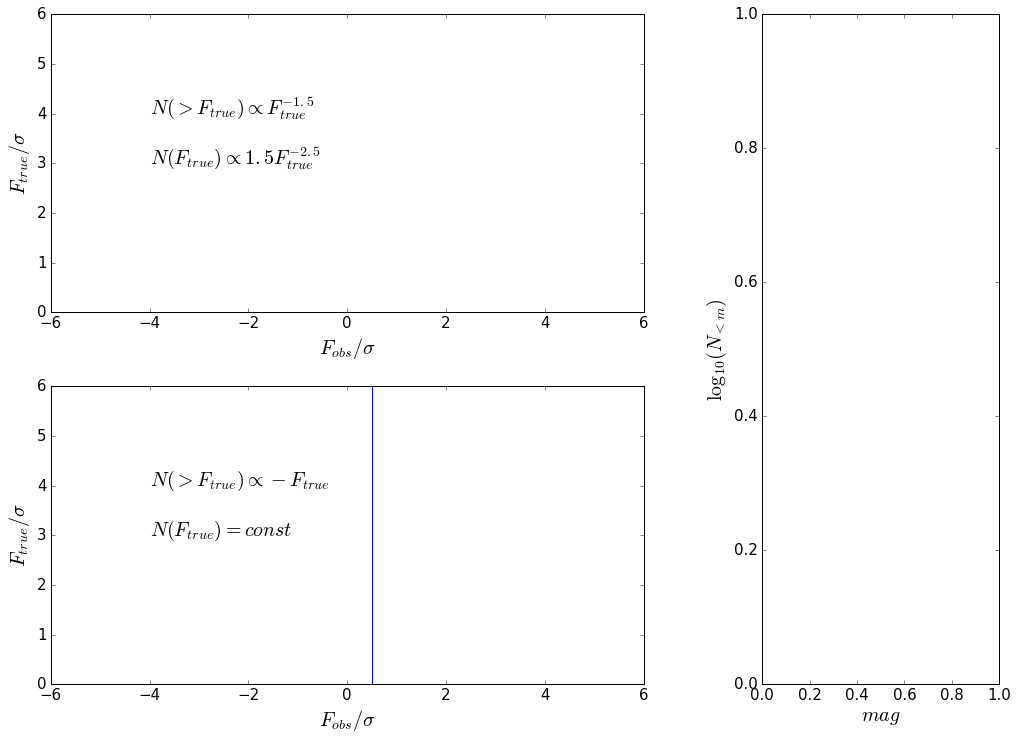

In [153]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(17,12))
gs = gridspec.GridSpec(2, 3)
ax = dict()
ax[0] = plt.subplot(gs[0, :2])
ax[1] = plt.subplot(gs[1, :2])
ax[2] = plt.subplot(gs[:2, 2])
ax[1].axvline(0.5)

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$F_{true} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$F_{obs} / \sigma$', fontsize=20)
ax[2].set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=20)
ax[2].set_xlabel(r'$mag$', fontsize=20)
gs.update(hspace=0.25,wspace=0.5)
xlim = [-6,6]
ylim = [0.01, 6]
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].text(-4,4, r'$N(>F_{true}) \propto F_{true}^{-1.5}$', fontsize=20)  # in data coordinates 
ax[0].text(-4,3, r'$N(F_{true})  \propto 1.5 F_{true}^{-2.5}$', fontsize=20)  # in data coordinates 
ax[1].set_xlim(xlim[0], xlim[1])
ax[1].set_ylim(ylim[0], ylim[1])
ax[1].text(-4,4, r'$N(>F_{true}) \propto -F_{true}$', fontsize=20) 
ax[1].text(-4,3, r'$N(F_{true}) = const$', fontsize=20) 
#plt.tight_layout()
plt.savefig(dir_save+'test_gridspec_environ.png',bbox_inches='tight')

## Plot 2 : Illustrate p(F)  for a faint point with negative distribution tails

Calculate <F_obs> , second-moment of the likelihood, etc.... 
Essentially, it is the faint source treatment from my other work 

In [49]:
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import faintFunctions as faintF 

### Read in the results of direct integration, interpolate at x_obs_dic from the Fig 1

In [198]:
euc_prior[:,3]

IndexError: index 3 is out of bounds for axis 1 with size 3

In [196]:
# read in results of direct integration as an interpolation table...
dir_data  = '/astro/users/suberlak/S13Agg_analysis/data_products/'
euc_prior = np.loadtxt(dir_data+ 'Fig3_xObs_xMean_xRms_euc_prior.txt')
flat_prior = np.genfromtxt(dir_data +'Fig3_xObs_xMean_xRms_flat_prior.txt')

xObs = euc_prior[:,0]

xMean_euc = euc_prior[:,1]
xRms_euc = euc_prior[:,2]

xMean_flat = flat_prior[:,1]
xRms_flat =flat_prior[:,2]
from collections import OrderedDict
# Interpolate results :  from the tabulated results for xp = FobsSim, fp =  expF,   
# need to extrapolate expF on points  defined by x= F_faint   
# xp must be increasing - but FobsSim already is :) 


x_mean_dic = OrderedDict()
x_mean_dic['flat_prior'] = OrderedDict()
x_mean_dic['euc_prior'] = OrderedDict()
x_rms_dic = OrderedDict()
x_rms_dic['flat_prior'] = OrderedDict()
x_rms_dic['euc_prior'] = OrderedDict()


for key in x_obs_dic.keys():
    x_obs = x_obs_dic[key] 
    x_mean_flat = np.interp(x = x_obs, xp = xObs ,fp= xMean_flat)
    x_rms_flat =  np.interp(x = x_obs, xp = xObs ,fp= xRms_flat)
    x_mean_euc = np.interp(x = x_obs, xp = xObs ,fp= xMean_euc)
    x_rms_euc = np.interp(x = x_obs, xp = xObs ,fp= xRms_euc)

    x_mean_dic['flat_prior'][key] = x_mean_flat
    x_mean_dic['euc_prior'][key] = x_mean_euc
    x_rms_dic['flat_prior'][key] = x_rms_flat
    x_rms_dic['euc_prior'][key] = x_rms_euc




### Plot the results of integration for Fig.3

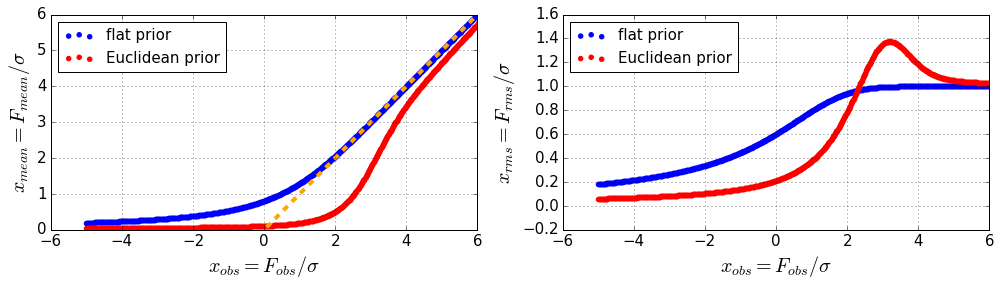

In [46]:
%matplotlib inline
fig,ax = plt.subplots(1,2, figsize=(14, 4.09))
# flat prior
ax[0].plot(xObs, xObs, ls='--', color='orange', lw=4)
ax[0].scatter(xObs, xMean_flat, color='blue', label='flat prior')
ax[1].scatter(xObs, xRms_flat, color='blue', label='flat prior')

# Euclidean prior 
ax[0].scatter(xObs, xMean_euc, color='red', label='Euclidean prior')
ax[1].scatter(xObs, xRms_euc, color='red',label='Euclidean prior')

ax[0].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[0].set_ylabel(r'$x_{mean}= F_{mean} / \sigma$', fontsize=20)
ax[1].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$x_{rms}= F_{rms} / \sigma$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()
ax[1].grid()
ax[0].legend(loc='upper left', fontsize=15)
ax[1].legend(loc='upper left', fontsize=15)
ax[0].set_xlim(-6,6)
ax[1].set_xlim(-6,6)
ax[0].set_ylim(0,6)
fig.subplots_adjust(wspace=0.3,)
plt.tight_layout()
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_direct_integration_priors.pdf')

### Plot r and chi vs F_true and F_obs  for combinations of (Euclidean_prior, Flat_prior) x (Euclidean_counts, Const_counts)

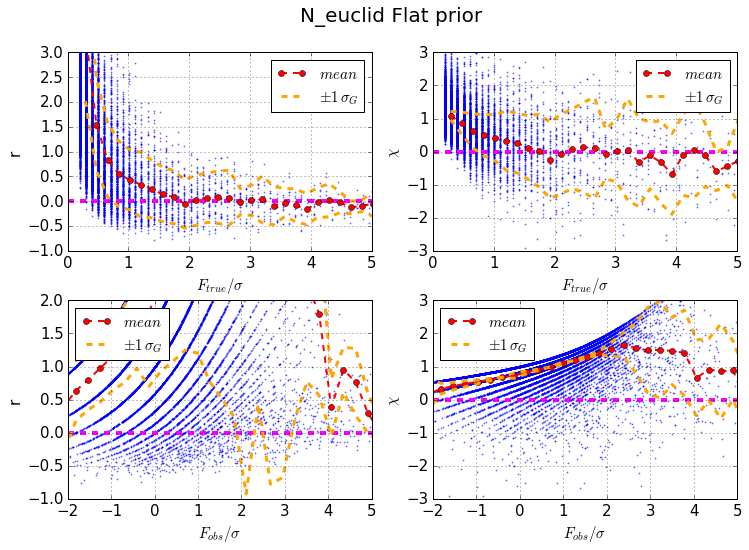

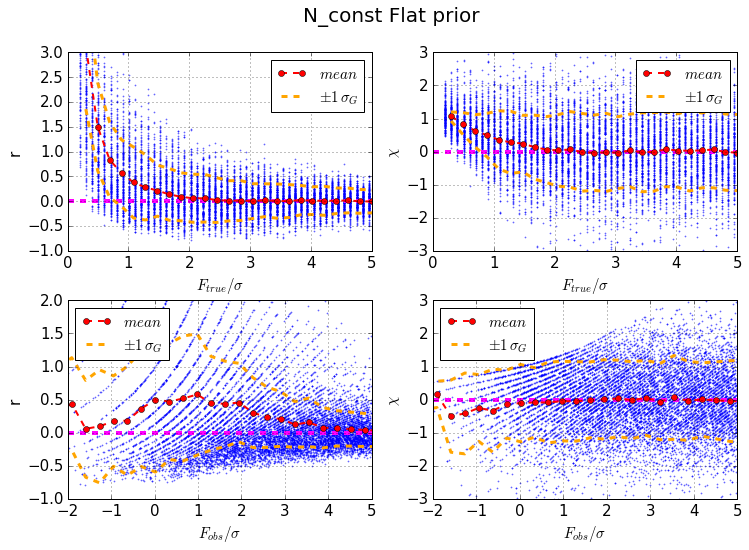

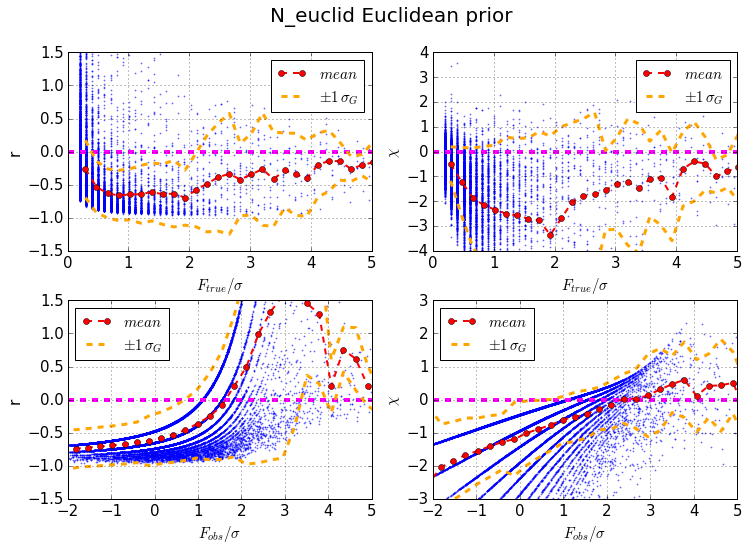

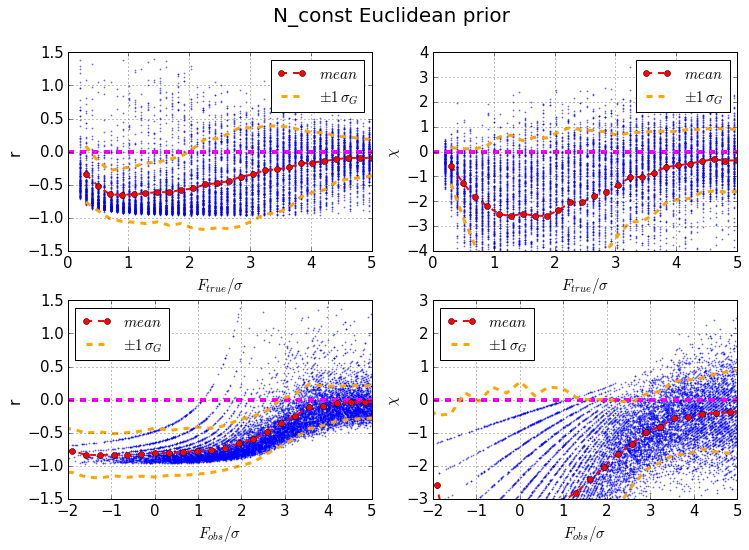

In [12]:
%matplotlib inline 

#  analytical calculation...
#sigma_obs = np.ones_like(x_true_flatten) * sigma
#f_obs_flatten = x_obs_flatten * sigma
#f_obs_mean = faintF.calculate_mean(f_obs_flatten, sigma_obs)
#f_obs_rms = faintF.calculate_rms(f_obs_flatten, sigma_obs)
#x_mean_an = f_obs_mean / sigma 
#x_rms_an = f_obs_rms / sigma 

#x_mean_arr = {'flat_prior':x_mean_flat,  'euc_prior':x_mean_euc } # 'flat_analytical':x_mean_an 
#x_rms_arr = {'flat_prior':x_rms_flat,  'euc_prior':x_rms_euc}  # 'flat_analytical':x_rms_an 

env_color='orange'  # color of the +/- 1 robust sigma envelope 

zer_color ='magenta' # parameters of the 0 line 
zer_lw = 4
zer_ls = '--'

scatter_alpha = 0.6 # parameters of the scatter points 

nbins = 50 

for prior in x_mean_dic.keys():
    for distribution in x_mean_dic[prior].keys():
    
        fig,axs =  plt.subplots(2,2, figsize=(12,8))
        ax = np.ravel(axs)

        # plotted quantities 
        x_mean = x_mean_dic[prior][distribution]
        x_rms = x_rms_dic[prior][distribution]
        x_true = x_true_dic[distribution]
        x_obs = x_obs_dic[distribution]
        
        r = (x_mean - x_true) / x_true
        chi = (x_mean - x_true ) / x_rms

        # robust sigma 
        def sigma_robust(x):
            return 0.7414*np.percentile(x,75) - np.percentile(x,25)

        # top left panel 
        mean, bin_edges, bin_num = binned_statistic(x=x_true, values=r, statistic='mean', bins=nbins)
        sigmaG, bin_edges, bin_num = binned_statistic(x=x_true, values=r, statistic=sigma_robust, bins=nbins)
        bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
        ax[0].scatter(x_true, r, lw=0, s=3, alpha=scatter_alpha)
        ax[0].set_xlabel(r'$F_{true} / \sigma$', fontsize=15)
        ax[0].set_ylabel('r', fontsize=15)
        ax[0].axhline(0, color=zer_color, ls=zer_ls, lw=zer_lw)
        ax[0].plot(bin_cen, mean, color='red',ls='--', marker='o', lw=2,label=r'$mean$')
        ax[0].plot(bin_cen, mean+sigmaG, color=env_color, ls='--', lw=3, label = r'$\pm1 \, \sigma_{G}$')
        ax[0].plot(bin_cen, mean-sigmaG, color=env_color, ls='--', lw=3)
        ax[0].grid()
        ax[0].legend(loc='upper right', fontsize=15)
        if prior == 'euc_prior':
            ax[0].set_xlim(0,5)
            ax[0].set_ylim(-1.5,1.5)
        else : 
            ax[0].set_xlim(0,5)
            ax[0].set_ylim(-1,3)


        # top right panel 
        mean, bin_edges, bin_num = binned_statistic(x=x_true, values=chi, statistic='mean', bins=nbins)
        sigmaG, bin_edges, bin_num = binned_statistic(x=x_true, values=chi, statistic=sigma_robust, bins=nbins)
        bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
        ax[1].scatter(x_true, chi, lw=0, s=3, alpha=scatter_alpha)
        ax[1].set_xlabel(r'$F_{true} / \sigma$', fontsize=15)
        ax[1].set_ylabel(r'$\chi$', fontsize=15)
        ax[1].axhline(0, color=zer_color, ls=zer_ls, lw=zer_lw)
        ax[1].plot(bin_cen, mean, color='red',ls='--', marker='o', lw=2,label=r'$mean$')
        ax[1].plot(bin_cen, mean+sigmaG, color=env_color, ls='--', lw=3, label = r'$\pm1 \, \sigma_{G}$')
        ax[1].plot(bin_cen, mean-sigmaG, color=env_color, ls='--', lw=3)
        ax[1].grid()
        ax[1].legend(loc='upper right', fontsize=15)
        if prior == 'euc_prior':
            ax[1].set_xlim(0,5)
            ax[1].set_ylim(-4,4)
        else:
            ax[1].set_xlim(0,5)
            ax[1].set_ylim(-3,3)

        # bottom left 

        mean, bin_edges, bin_num = binned_statistic(x=x_obs, values=r, statistic='mean', bins=nbins)
        sigmaG, bin_edges, bin_num = binned_statistic(x=x_obs, values=r, statistic=sigma_robust, bins=50)
        bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
        ax[2].scatter(x_obs, r, lw=0, s=3, alpha=scatter_alpha)
        ax[2].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
        ax[2].set_ylabel('r', fontsize=15)
        ax[2].axhline(0, color=zer_color, ls=zer_ls, lw=zer_lw)
        ax[2].plot(bin_cen, mean, color='red',ls='--', marker='o', lw=2,label=r'$mean$')
        ax[2].plot(bin_cen, mean+sigmaG, color=env_color, ls='--', lw=3, label = r'$\pm1 \, \sigma_{G}$')
        ax[2].plot(bin_cen, mean-sigmaG, color=env_color, ls='--', lw=3)
        ax[2].grid()
        ax[2].legend(loc='upper left', fontsize=15)
        if prior == 'euc_prior':
            ax[2].set_xlim(-2,5)
            ax[2].set_ylim(-1.5,1.5)
        else:
            ax[2].set_xlim(-2,5)
            ax[2].set_ylim(-1,2)

        # bottom right 
        mean, bin_edges, bin_num = binned_statistic(x=x_obs, values=chi, statistic='mean', bins=nbins)
        sigmaG, bin_edges, bin_num = binned_statistic(x=x_obs, values=chi, statistic=sigma_robust, bins=50)
        bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
        ax[3].scatter(x_obs, chi, lw=0, s=3, alpha=scatter_alpha)
        ax[3].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
        ax[3].set_ylabel(r'$\chi$', fontsize=15)
        ax[3].axhline(0, color=zer_color, ls=zer_ls, lw=zer_lw)
        ax[3].plot(bin_cen, mean, color='red',ls='--', marker='o', lw=2, label=r'$mean$')
        ax[3].plot(bin_cen, mean+sigmaG, color=env_color,ls='--', lw=3, label = r'$\pm1 \, \sigma_{G}$')
        ax[3].plot(bin_cen, mean-sigmaG, color=env_color,ls='--', lw=3)
        ax[3].legend(loc='upper left', fontsize=15)
        ax[3].grid()
        ax[3].set_xlim(-2,5)
        ax[3].set_ylim(-3,3)

        for axis in ax:
            axis.tick_params(axis='both', which='major', labelsize=15)

        if prior == 'euc_prior':
            fig.suptitle(distribution + ' Euclidean prior', fontsize=20)
        else:
            fig.suptitle(distribution + ' Flat prior', fontsize=20)
        fig.subplots_adjust(hspace=0.25)
        plt.savefig(dir_save + 'Fig4_'+prior+'_'+distribution+'.png')

### Plot only  chi vs F_obs (bottom right)  for combinations of (Euclidean_prior, Flat_prior) x (Euclidean_counts, Const_counts)

flat_prior N_const
euc_prior N_euclid
flat_prior N_euclid
euc_prior N_const


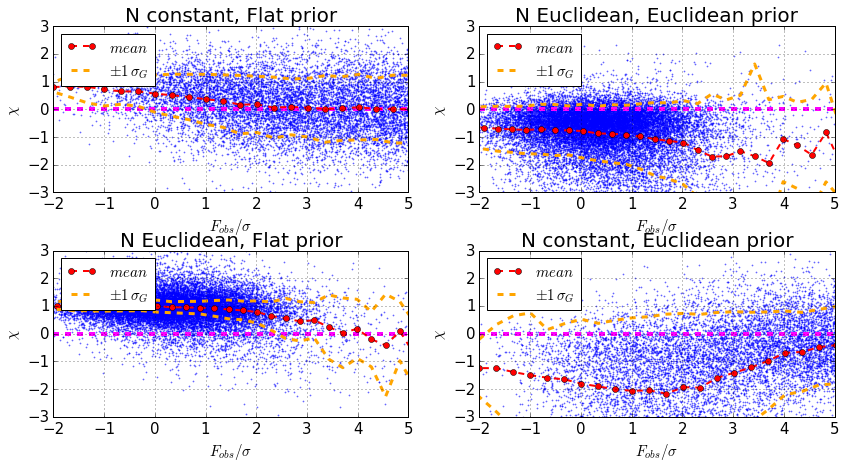

In [52]:
%matplotlib inline 

#  analytical calculation...
#sigma_obs = np.ones_like(x_true_flatten) * sigma
#f_obs_flatten = x_obs_flatten * sigma
#f_obs_mean = faintF.calculate_mean(f_obs_flatten, sigma_obs)
#f_obs_rms = faintF.calculate_rms(f_obs_flatten, sigma_obs)
#x_mean_an = f_obs_mean / sigma 
#x_rms_an = f_obs_rms / sigma 

#x_mean_arr = {'flat_prior':x_mean_flat,  'euc_prior':x_mean_euc } # 'flat_analytical':x_mean_an 
#x_rms_arr = {'flat_prior':x_rms_flat,  'euc_prior':x_rms_euc}  # 'flat_analytical':x_rms_an 

env_color='orange'  # color of the +/- 1 robust sigma envelope 

zer_color ='magenta' # parameters of the 0 line 
zer_lw = 4
zer_ls = '--'

scatter_alpha = 0.6 # parameters of the scatter points 

nbins = 50 
pairs = np.array([['flat_prior','N_const'],['euc_prior','N_euclid' ],   # correct ones 
                  ['flat_prior', 'N_euclid'],['euc_prior','N_const']])  # incorrect ones 

fig,axs =  plt.subplots(2,2, figsize=(14,7))
ax = np.ravel(axs)
i = 0
for pair in pairs: 
    prior, distribution = pair[0], pair[1]
    print prior, distribution
    # plotted quantities 
    x_mean = x_mean_dic[prior][distribution]
    x_rms = x_rms_dic[prior][distribution]
    x_true = x_true_dic[distribution]
    x_obs = x_obs_dic[distribution]

    # calculated quantity 
    chi = (x_mean - x_true ) / x_rms

    # robust sigma 
    def sigma_robust(x):
        return 0.7414*np.percentile(x,75) - np.percentile(x,25)

    # bottom right 
    mean, bin_edges, bin_num = binned_statistic(x=x_obs, values=chi, statistic='mean', bins=nbins)
    sigmaG, bin_edges, bin_num = binned_statistic(x=x_obs, values=chi, statistic=sigma_robust, bins=50)
    bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
    ax[i].scatter(x_obs, chi, lw=0, s=3, alpha=scatter_alpha)
    ax[i].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
    ax[i].set_ylabel(r'$\chi$', fontsize=15)
    ax[i].axhline(0, color=zer_color, ls=zer_ls, lw=zer_lw)
    ax[i].plot(bin_cen, mean, color='red',ls='--', marker='o', lw=2, label=r'$mean$')
    ax[i].plot(bin_cen, mean+sigmaG, color=env_color,ls='--', lw=3, label = r'$\pm1 \, \sigma_{G}$')
    ax[i].plot(bin_cen, mean-sigmaG, color=env_color,ls='--', lw=3)
    ax[i].legend(loc='upper left', fontsize=15)
    ax[i].grid()
    ax[i].set_xlim(-2,5)
    ax[i].set_ylim(-3,3)

    ax[i].tick_params(axis='both', which='major', labelsize=15)
    if distribution == 'N_euclid':
        dist = 'N Euclidean'
    else : 
        dist = 'N constant'

    if prior == 'euc_prior':
        pr  = 'Euclidean prior'
    else:
        pr = 'Flat prior'

    ax[i].set_title(dist + ', '+pr, fontsize=20)
    i += 1 

fig.subplots_adjust(hspace=0.35)
plt.savefig(dir_save + 'Fig4_only_chi_vs_F_true_horizontal.pdf', bbox_inches='tight')

In [11]:
len(x_obs)

19796

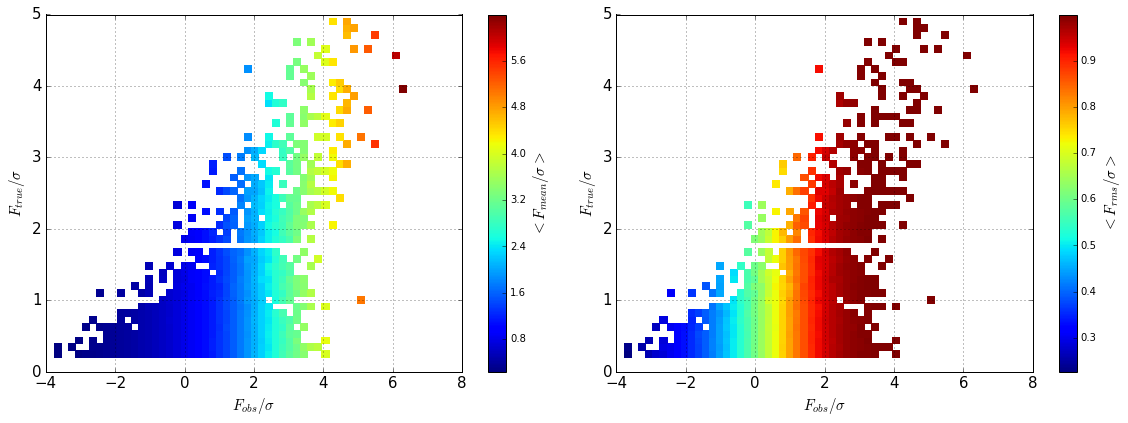

In [296]:
from scipy.stats import binned_statistic_2d

fig,ax = plt.subplots(1,2,figsize=(16,6))

# MEAN 
stats = binned_statistic_2d(y=x_true_flatten[m], x=x_obs_flatten[m], values=f_obs_mean[m] / sigma, statistic='mean', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
# plt.scatter(x_true_flatten, x_obs_flatten)
colorbar = fig.colorbar(image, ax = ax[0],  orientation='vertical')
colorbar.set_label(r'$<F_{mean} / \sigma>$', fontsize=15)
ax[0].set_ylabel(r'$F_{true} / \sigma$', fontsize=15)
ax[0].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].grid()

# RMS  
stats = binned_statistic_2d(x=x_obs_flatten[m], y=x_true_flatten[m],  values=f_obs_rms[m] / sigma, statistic='mean', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
# plt.scatter(x_true_flatten, x_obs_flatten)
colorbar = fig.colorbar(image, ax = ax[1],  orientation='vertical')
colorbar.set_label(r'$<F_{rms} / \sigma>$', fontsize=15)
ax[1].set_ylabel(r'$F_{true} / \sigma$', fontsize=15)
ax[1].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].grid()
plt.tight_layout()
plt.savefig(dir_save+'Sim_x_true_x_obs_2D_hist_rms_mean.png')

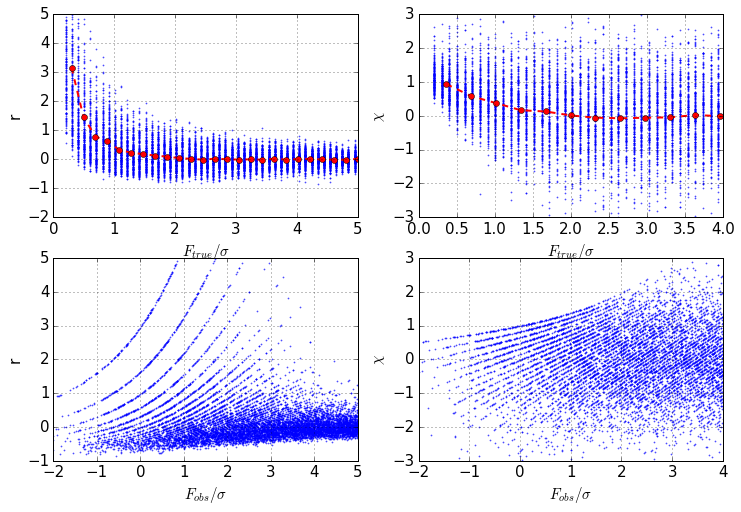

In [67]:
# purely analytical 
%matplotlib inline 
fig,axs =  plt.subplots(2,2, figsize=(12,8))
ax = np.ravel(axs)


sigma_obs = np.ones_like(x_true_flatten) * sigma
f_obs_flatten = x_obs_flatten * sigma

f_obs_mean = faintF.calculate_mean(f_obs_flatten, sigma_obs)
f_obs_rms = faintF.calculate_rms(f_obs_flatten, sigma_obs)

f_true_flatten = x_true_flatten * sigma
r = (f_obs_mean - f_true_flatten) / f_true_flatten
stats, bin_edges, bin_num = binned_statistic(x=x_true_flatten, values=r, statistic='mean', bins=50)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax[0].scatter(x_true_flatten, r, lw=0, s=3, alpha=0.7)
ax[0].set_xlabel(r'$F_{true} / \sigma$', fontsize=15)
ax[0].set_ylabel('r', fontsize=15)
ax[0].plot(bin_cen, stats, color='red',ls='--', marker='o', lw=2)
ax[0].grid()
ax[0].set_xlim(0,5)
ax[0].set_ylim(-2,5)
for axis in ax:
    axis.tick_params(axis='both', which='major', labelsize=15)

chi = (f_obs_mean - f_true_flatten ) / f_obs_rms
stats, bin_edges, bin_num = binned_statistic(x=x_true_flatten, values=chi, statistic='mean', bins=30)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax[1].scatter(x_true_flatten, chi, lw=0, s=3, alpha=0.7)
ax[1].set_xlabel(r'$F_{true} / \sigma$', fontsize=15)
ax[1].set_ylabel(r'$\chi$', fontsize=15)
ax[1].plot(bin_cen, stats, color='red',ls='--', marker='o', lw=2)
ax[1].grid()
ax[1].set_xlim(0,4)
ax[1].set_ylim(-3,3)

ax[2].scatter(x_obs_flatten, r, lw=0, s=3, alpha=0.7)
ax[2].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax[2].set_ylabel('r', fontsize=15)
ax[2].grid()
ax[2].set_xlim(-2,5)
ax[2].set_ylim(-1,5)

ax[3].scatter(x_obs_flatten, chi, lw=0, s=3, alpha=0.7)
ax[3].set_xlabel(r'$F_{obs} / \sigma$', fontsize=15)
ax[3].set_ylabel(r'$\chi$', fontsize=15)
ax[3].grid()
ax[3].set_xlim(-2,4)
ax[3].set_ylim(-3,3)
plt.savefig(dir_save + 'Fig4_stats_flat_prior_analytical.png')

### Plot 2 : Illustrate p(F)  for a faint point with negative distribution tails

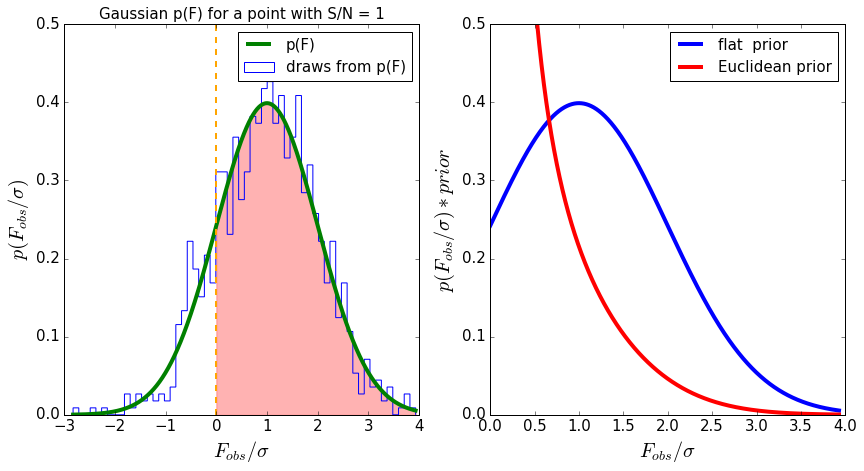

In [50]:
from scipy.stats import norm

x_true = 1
width = 1
#np.random.seed(24)
x_obs = np.random.normal(loc=x_true, scale = width, size = 1000)
fig,ax = plt.subplots(1,2, figsize=(14,7))
ax[0].hist(x_obs, normed=True, bins=60, histtype='step' , label='draws from p(F)')

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(min(x_obs), max(x_obs), 0.001)
# Mean = 0, SD = 2.
ax[0].plot(x_axis,norm.pdf(x_axis,x_true,width), lw=4 , label='p(F)')

# mark the zero
ax[0].axvline(0,lw=2,ls='--', color='orange')

# mark the posterior
# ax.plot([x1,x2], [y1,y2]) to draw a line from x1,y1 to x2,y2
#ax.plot([min(x_obs), 0], [0, 0], ls='-', color='red', lw=4)
#ax.plot([0,0], [0,norm.pdf(0,x_true,width)],ls='-', color='red', lw=4)

# shade the positive part 
mask = x_axis>0
ax[0].fill_between(x_axis[mask],norm.pdf(x_axis[mask],x_true,width), alpha=0.3, color='red' )

ax[0].set_ylim(-.01)
ax[0].set_ylabel(r'$p(F_{obs}/\sigma)$', fontsize=20)
ax[0].set_xlabel(r'$F_{obs}/\sigma$', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15)
# save the plot 
ax[0].set_title('Gaussian p(F) for a point with S/N = 1', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].set_ylim(0,0.5)


# Plotonly the positive part 
x_pos = x_axis[x_axis>0]
y = norm.pdf(x_axis,x_true,width)
y_pos = y[x_axis>0]
ax[1].plot(x_pos,y_pos, lw=4 , color='b', label='flat  prior')

# use Euclidean posterior :  p(F) ~ F**(-1.5)
delx = x_pos[1] - x_pos[0]
normalize = np.sum(delx *x_pos**(-1.5))
euclid_norm  = x_pos**(-1.5)  / normalize
ax[1].plot(x_pos, 100*euclid_norm* y_pos, lw=4 , color='red', label='Euclidean prior' )
ax[1].set_ylim(0,0.5)
ax[1].legend(fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].set_ylabel(r'$p(F_{obs}/\sigma) * prior$', fontsize=20)
ax[1].set_xlabel(r'$F_{obs}/\sigma$', fontsize=20)
plt.savefig(dir_save + 'Fig2_pF_illustrate.pdf', bbox_inches='tight')

(0, 1)

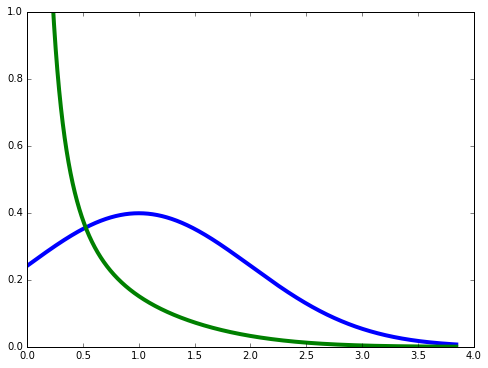

In [281]:
from scipy.stats import norm

x_true = 1
width = 1
#np.random.seed(24)
x_obs = np.random.normal(loc=x_true, scale = width, size = 1000)
fig,ax = plt.subplots(figsize=(8,6))

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(min(x_obs), max(x_obs), 0.001)
# Mean = 0, SD = 2.
y = norm.pdf(x_axis,x_true,width)
x_pos = x_axis[x_axis>0]
y_pos = y[x_axis>0]
ax.plot(x_pos,y_pos, lw=4 , label='flat  prior')


# use Euclidean posterior :  p(F) ~ F**(-1.5)
normalize = np.sum(delx *x_pos**(-1.5))

y  = x_pos**(-1.5)  / normalize
ax.plot(x_pos, 100*y* y_pos, lw=4 , label='Euclidean prior' )
ax.set_ylim(0,1)

In [244]:
delx = x_axis[1] - x_axis[0]
np.sum(delx*y)

0.99621554162454684

94.322504423817662

(0.0, 1)

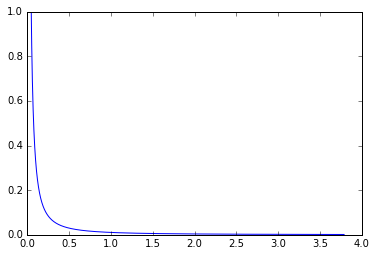

In [256]:
normalize = np.sum(delx *x_pos**(-1.5))
y  = x_pos**(-1.5)  / normalize

plt.plot(x_pos,  y)
plt.ylim(ymax=1)

In [255]:
y

array([  4.39579418e+02,   1.34900500e+02,   7.02439290e+01, ...,
         1.44041101e-03,   1.43984018e-03,   1.43926974e-03])

## Plot 3 : Illustrate the magnitude depth recovered  by faint signal treatment beyond  $2\sigma$...  

Euclidean number of counts in relation to magnitude obeys : 
    
$N(m) \propto 10^{0.6m}$

In [323]:
ax.text?

2 sigma limit mag is 23.881135
5 sigma limit mag is 22.886285


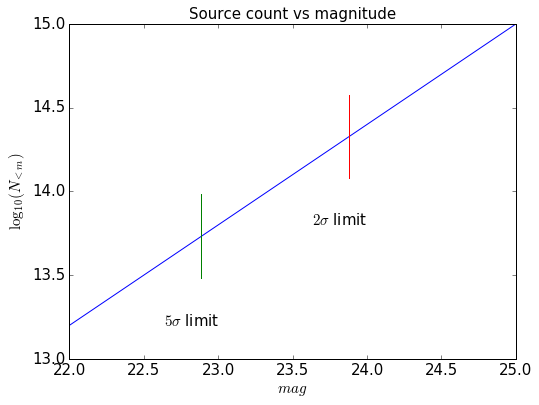

In [37]:
m = np.linspace(22,25,100)
mean_sigma = np.median(fp_data['psfFluxErr'].values) #1.2E-30
m_2sig = -2.5 * np.log10(2*mean_sigma) - 48.6
m_5sig = -2.5 * np.log10(5*mean_sigma) - 48.6
print('2 sigma limit mag is %f'%m_2sig)
print('5 sigma limit mag is %f'%m_5sig)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(m, np.log10(10**(0.6*m)))

# plot 5 sigma limit 
linesize = 0.25
y1y2 = [ np.log10(10**(0.6*m_5sig))-linesize,np.log10(10**(0.6*m_5sig))+linesize]
x1x2 = [m_5sig, m_5sig ]
ax.plot(x1x2, y1y2)
ax.text(x=m_5sig-0.25,y=13.2,s=r'$5 \sigma$ limit', fontsize=15)

# plot 2 sigma limit 
linesize = 0.25
y1y2 = [ np.log10(10**(0.6*m_2sig))-linesize,np.log10(10**(0.6*m_2sig))+linesize]
x1x2 = [m_2sig, m_2sig ]
ax.plot(x1x2, y1y2)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.text(x=m_2sig-0.25,y=13.8,s=r'$2 \sigma$ limit', fontsize=15)
ax.set_xlabel(r'$mag$', fontsize=15)
ax.set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=15)
ax.set_title('Source count vs magnitude', fontsize=15)
plt.savefig(dir_save+'Source_count_vs_magnitude.png')

I could measure the N(m) : take several thousands of the raw FP lightcurves, do the faint-point treatment, recalculate to magnitudes, and plot how many points do we have in total up to a certain magnitude (cumulative distribution)

In [32]:

DirIn = '/astro/store/scratch/tmp/suberlak/S13Agg/rawDataFPSplit/'
name = 'g00_21.csv'
fp_data = pd.read_csv(DirIn+name+'.gz', compression='gzip',  
                     usecols=['objectId', 'mjd', 'psfFlux', 'psfFluxErr'], nrows=10000)


In [33]:
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import faintFunctions as faintF 

In [34]:
####  first drop all NaNs  in psfFlux...      
m1  = np.isnan(fp_data['psfFlux'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFlux']) #  True if not finite  
m  = m1 | m2  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)  # drop entire rows 
    print('Okay, we dropped %d rows where psfFlux is NaN or inf'%np.sum(m))

#### check to make sure that there are no NaN or 0 psfFluxErr... 
m1  = np.isnan(fp_data['psfFluxErr'])  # True if NaN  
m2 =  ~np.isfinite(fp_data['psfFluxErr']) #  True if not finite
m3 =   fp_data['psfFluxErr'].values == 0 # True if Err == 0  (IN2P3 problem...)
m  = m1 | m2 | m3  # a logical or 
if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    fp_data.drop(m.index[m], inplace=True)
    print('Okay, we dropped %d rows where psfFluxErr is NaN or inf'%np.sum(m))

# make a new column, fill with 0's
fp_data['flagFaint'] = 0

# mask those rows that correspond to SNR < 2
mask = (fp_data['psfFlux'].values / fp_data['psfFluxErr'].values) < 2

# print info how many points are affected
print('There are %d points of %d that have SNR<2' %(np.sum(mask),len(mask)))

# set flag at those rows to 1
fp_data.ix[mask, 'flagFaint'] = 1

# make new columns for  Mean  Median  2 sigma...
fp_data['faintMean'] = np.nan
fp_data['faintMedian'] = np.nan
fp_data['faintTwoSigma'] = np.nan
fp_data['faintRMS'] = np.nan
# calculate the faint replacement only for faint points...
print('Faint points treatment...')
fp_data.ix[mask, 'faintMean'] = faintF.calculate_mean(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintMedian'] = faintF.calculate_median(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintTwoSigma'] = faintF.calculate_2sigma(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)
fp_data.ix[mask, 'faintRMS'] = faintF.calculate_rms(fp_data['psfFlux'][mask].values,fp_data['psfFluxErr'][mask].values)

#
##########  STEP 2 : Derived Quantities ###########  
#

####  replace all psfFlux  where SNR < 2  with  faintMean  
rows = fp_data['flagFaint'] == 1
fp_data.ix[rows, 'psfFlux'] = fp_data.ix[rows, 'faintMean']

def flux2absigma(flux, fluxsigma):
  """Compute AB mag sigma given flux and flux sigma"""
  FIVE_OVER_2LOG10 = 1.085736204758129569
  return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux):
  """Compute AB mag given flux"""
  return -2.5 * np.log10(flux) - 48.6;

fp_data['psfMag'] = flux2ab(fp_data['psfFlux'])
fp_data['psfMagErr'] = flux2absigma(fp_data['psfFlux'],fp_data['psfFluxErr'])

print('Calculating magnitudes from fluxes is finished')

There are 5464 points of 10000 that have SNR<2
Faint points treatment...
Calculating magnitudes from fluxes is finished


offset b=-10.406611


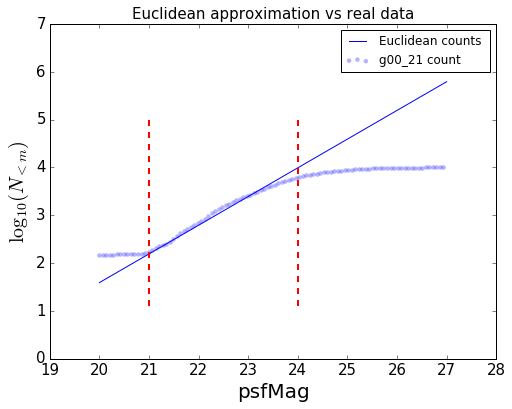

In [38]:
m = np.linspace(20,27,100)
N_cumulative = np.zeros_like(m)
N_between_m = np.zeros_like(m)
for i in range(len(m)-1):
    N_between_m[i] = np.sum((fp_data['psfMag'].values >m[i])&(fp_data['psfMag'].values <m[i+1]))
    N_cumulative[i] = np.sum(fp_data['psfMag'].values < m[i])
    

from scipy.optimize import curve_fit

def func(m, b):
    return np.log10(10**(0.6*m))+b

mask = (m>22) & (m<24)
popt, pcov = curve_fit(func, m[mask], np.log10(N_cumulative[mask]))

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(m, np.log10(N_cumulative),  label='g00_21 count', alpha=0.3, lw=0)
ax.plot(m, func(m,popt[0]), label='Euclidean counts ')
ax.legend(loc='best', fontsize=12)
ax.set_ylabel(r'$\log_{10}(N_{<m})$', fontsize=20)
ax.set_xlabel('psfMag', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.plot([21,21],[1.1,5], color='red', ls='--', lw=2)
ax.plot([24,24],[1.1,5], color='red', ls='--', lw=2)
ax.set_title('Euclidean approximation vs real data', fontsize=15)
plt.savefig(dir_save+'Simulated_vs_obs_counts_one_patch_raw_FP.png')
print('offset b=%f'%popt[0])

The plot above shows the cdf of counts up to a given magnitude. In a window of $21<m<24$ we fitted functional form  $N = 10^{0.6m}+b$, with best fit offset   $b=-10.4$